In [37]:
import pandas as pd
import seaborn as sns
import numpy as np

Events_Sequence = pd.read_csv('Events_Sequence.txt', sep = '\t')

aircraft = pd.read_csv('aircraft.txt')
ev_ID = sum(aircraft.values.tolist(), [])

In [38]:
Events_Sequence.head(2)

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20001208X08803,1,3,400240,Enroute - Loss of control in flight,400,240,1,5/13/2019 14:50:49,bowl
1,20001212X19469,1,1,550900,Landing - Miscellaneous/other,550,900,1,6/25/2015 14:54:25,sedj


In [39]:
new = Events_Sequence["Occurrence_Description"].str.split("-", n = 1, expand = True)

Events_Sequence.insert(5, 'Phase', 'Unknown')
Events_Sequence.insert(6, 'Description', 'Unknown')
Events_Sequence['Phase'] = new[0].str.strip()
Events_Sequence['Description'] = new[1].str.strip()

In [40]:
Events_Sequence.head()

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,Phase,Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20001208X08803,1,3,400240,Enroute - Loss of control in flight,Enroute,Loss of control in flight,400,240,1,5/13/2019 14:50:49,bowl
1,20001212X19469,1,1,550900,Landing - Miscellaneous/other,Landing,Miscellaneous/other,550,900,1,6/25/2015 14:54:25,sedj
2,20010304X00536,1,1,400350,Enroute - Security/criminal event,Enroute,Security/criminal event,400,350,1,6/25/2015 15:51:08,sedj
3,20010304X00536,2,1,400350,Enroute - Security/criminal event,Enroute,Security/criminal event,400,350,1,6/25/2015 15:51:23,sedj
4,20080109X00036,1,1,551230,Landing-flare/touchdown - Loss of control on g...,Landing,flare/touchdown - Loss of control on ground,551,230,1,11/16/2017 13:41:08,broda


In [41]:
second_phases = ['cruise', 'flare/touchdown', 'aerobatics', 'climb to cruise', 'landing roll', 'IFR initial approach', 
                 'IFR final approach', 'IFR missed approach', 'low-alt flying', 'VFR go-around', 'descent', 
                 'VFR pattern final', 'rejected takeoff', 'circling (IFR)']
def f(x):
    if '-' in x:
        if x.split('-')[0].strip() in second_phases:
            return x.split('-', 1)[1].strip()
    else:
        return x

Events_Sequence['Description'] = Events_Sequence['Description'].map(f)

#### Accident proportion by phases

In [42]:
df_events_sequences = Events_Sequence[Events_Sequence['ev_id'].isin(ev_ID)]

df_events_sequences.reset_index(inplace=True)
del df_events_sequences['index']

In [43]:
df_events_sequences.head()

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,Phase,Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20080118X00073,1,1,200200,Pushback/towing - Ground collision,Pushback/towing,Ground collision,200,200,1,2/2/2009 13:27:45,mcgk-c
1,20080118X00073,2,1,200200,Pushback/towing - Ground collision,Pushback/towing,Ground collision,200,200,1,2/2/2009 13:28:51,mcgk-c
2,20080222X00229,1,1,401900,Enroute-climb to cruise - Miscellaneous/other,Enroute,Miscellaneous/other,401,900,1,12/23/2008 15:40:20,stam
3,20080222X00229,1,2,402900,Enroute-cruise - Miscellaneous/other,Enroute,Miscellaneous/other,402,900,0,12/23/2008 15:40:20,stam
4,20080305X00267,1,1,404360,Enroute-descent - Turbulence encounter,Enroute,Turbulence encounter,404,360,1,7/28/2009 14:59:12,grol


In [44]:
import collections

counter = collections.Counter(df_events_sequences['Phase'])
counter

Counter({'Pushback/towing': 20,
         'Enroute': 170,
         'Taxi': 48,
         'Standing': 41,
         'Takeoff': 34,
         'Landing': 91,
         'Prior to flight': 25,
         'Initial climb': 37,
         'Approach': 46,
         'Pushback/tow': 14,
         'Post': 6,
         'Other': 9,
         'Unknown': 4,
         'Emergency descent': 2,
         'Uncontrolled descent': 1,
         'After landing': 4})

Text(0, 0.5, 'Proportion')

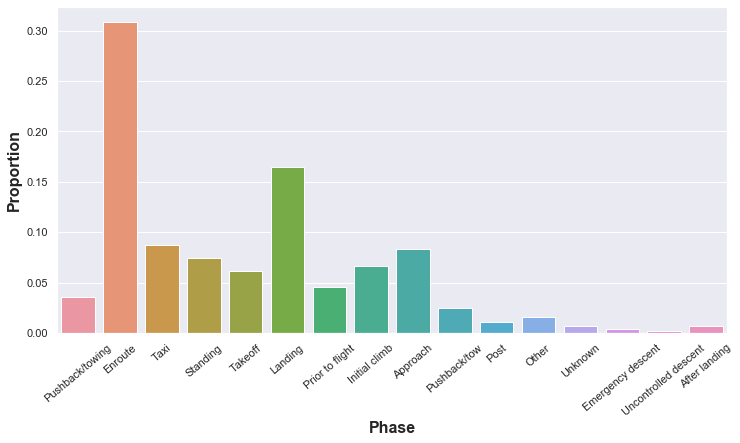

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

proportion = np.array(list(counter.values()))/sum(list(counter.values()))

plt.figure(figsize = (12, 6))
sns.barplot(x = list(counter.keys()), y = proportion)
sns.set(font_scale=1)
plt.xticks(rotation=40)
plt.xlabel('Phase', fontsize = 16, fontweight = 'bold')
plt.ylabel('Proportion', fontsize = 16, fontweight = 'bold')

#### Create raw transition graph from the Table Events_Sequence

In [46]:
nodeDesp = list(df_events_sequences['Description'].unique())

In [47]:
def findDespByID(ID):
    desp = df_events_sequences.loc[df_events_sequences['ev_id'] == ID]
    return list(desp['Description'])

dictEdges = {}

for ID in df_events_sequences['ev_id']:
    desp = findDespByID(ID)
    
    if len(desp) == 1:
        nodeFrom = nodeDesp.index(desp[0])
        nodeTo = nodeDesp.index(desp[0])
        
        key = str(nodeFrom)
        
        if key in dictEdges.keys():
            dictEdges[key] = dictEdges[key] + 1  
        else:
            dictEdges[key] = 1    
    else:
        for i in range(len(desp) - 1):
            nodeFrom = nodeDesp.index(desp[i])
            nodeTo = nodeDesp.index(desp[i+1])

            key = str(nodeFrom) + '->' + str(nodeTo)
            
            if key in dictEdges.keys():
                dictEdges[key] = dictEdges[key] + 1
            else:
                dictEdges[key] = 1

In [48]:
import operator

sorted_x = sorted(dictEdges.items(), key=operator.itemgetter(1))

In [49]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='jpg', prog='dot'))

g1 = """digraph top {
    size ="12,12";
    main [shape=box]; /* this is a comment */
    main -> parse [weight=80];
    main -> main [style=bold, label="0.20"];
    parse -> execute;
    main -> init [style=dotted];
    main -> cleanup;
    execute -> { make_string; printf}
    init -> make_string;
    edge [color=red]; // so is this
    main -> printf [style=bold,label="100 times"];
    make_string [label="make a\nstring"];
    node [shape=box,style=filled,color=".7 .3 1.0"];
    execute -> compare;
}"""

In [50]:
def create_graph():
    g = """digraph top {
    size ="12,12";"""
    
    for key, value in dictEdges.items():
        
        if '->' in key:
            nodeFrom = key.split('->')[0]
            nodeTo = key.split('->')[1]
            g += str(nodeFrom) + '->' + str(nodeTo) + '[style=bold, label=' + str(value) + ']'
  
    g += '}'
    
    return g

In [51]:
nodeDesp[21]

'Fire/smoke (non-impact)'

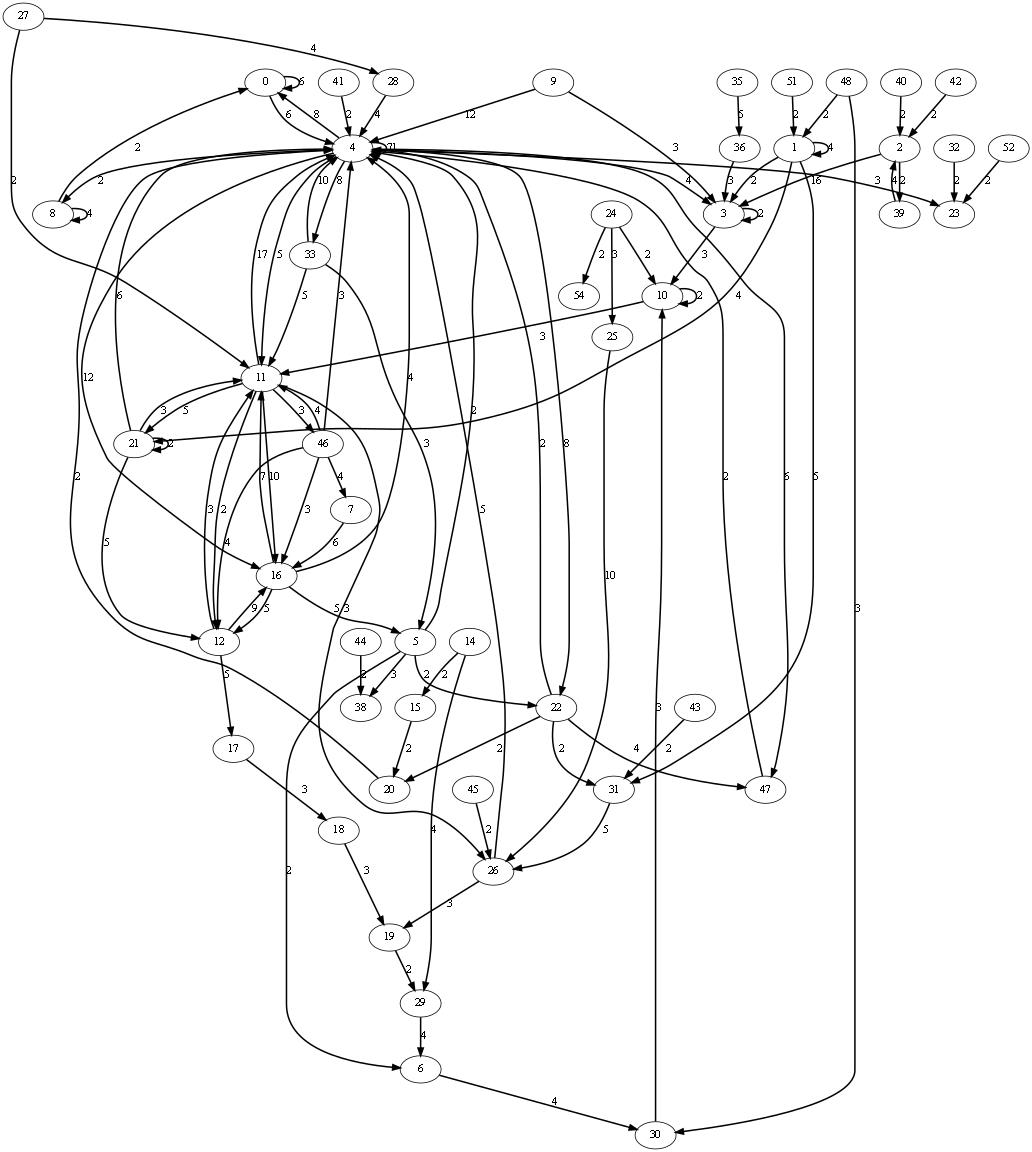

In [52]:
g = create_graph()
draw(g)

#### Create Bayesian network from Table seq_of_events

In [53]:
seq_of_events = pd.read_csv('seq_of_events.txt', sep = '\t')
eventCodes = pd.read_csv('ct_seqevt.txt')

In [54]:
eventCodes.head()

,code,meaning
0,100,ABRUPT MANEUVER
1,110,"ALTITUDE DEVIATION,UNCONTROLLED"
2,120,CARGO SHIFT
3,130,AIRFRAME/COMPONENT/SYSTEM FAILURE/MALFUNCTION
4,131,PROPELLER FAILURE/MALFUNCTION


In [55]:
df_seq_of_events = seq_of_events[seq_of_events['ev_id'].isin(ev_ID)].copy()

index = df_seq_of_events[df_seq_of_events['Subj_Code'] == 0].index.tolist()[0]
df_seq_of_events.drop(df_seq_of_events.index[6218], inplace = True)
df_seq_of_events.reset_index(inplace=True)
del df_seq_of_events['index']

In [56]:
df_seq_of_events = df_seq_of_events.head(1000)

In [57]:
df_seq_of_events.head()

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,C,3130,4111.0,1/10/2001 10:43:11,dbo
3,20001212X18554,1,1,3,4,90000,F,0,6110.0,1/10/2001 10:43:11,dbo
4,20001212X18554,1,1,4,2,24604,F,3134,4111.0,1/10/2001 10:43:11,dbo


In [58]:
df_seq_of_events.insert(6, 'Grouped_Subject_Code', None)

In [59]:
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Subj_Code'].copy()

def updateGroupSubjectCode(code):
    #codeList = [24600, 24500, 10400, 24000, 19000, 10700, 12000, 12100, 19200, 14100, 14300,
    #            33000, 12900, 10000, 20200, 22100, 23300, 24100, 16900, 17000, 10300]
    codeList = []
    
    if int(str(code)[:-2] + '00') in codeList:
        return code
    else:
        return int(str(code)[:-2] + '00')
        
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(updateGroupSubjectCode)

In [60]:
df_seq_of_events.head()

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,10400,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,24600,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,24600,C,3130,4111.0,1/10/2001 10:43:11,dbo
3,20001212X18554,1,1,3,4,90000,90000,F,0,6110.0,1/10/2001 10:43:11,dbo
4,20001212X18554,1,1,4,2,24604,24600,F,3134,4111.0,1/10/2001 10:43:11,dbo


In [61]:
def findKeyByValue(val, highLevelGroup):
    for k, v in highLevelGroup.items():
        if val in v:
            return k
        
def mapToHigherLevel(code):
    highLevelGroup = {
        31000: [31100, 31200],
        33000: [33100, 33200, 33300, 33400, 33500, 33600, 33700],
        34000: [34100, 34200, 34300],
        35000: [35100, 35200, 35300],
        70000: [70100],
        80000: [80100, 80200, 80300, 80400],
        84000: [84100, 84200],
        90000: [90100, 90200], 
        91000: [91100, 91200, 91300, 91400, 91500], 
        92000: [92100, 92200, 92300, 92400],
        93000: [93100, 93200, 93300]
    }
    
    allValues = sum(list(highLevelGroup.values()), []) 
    
    if code in allValues:
        key = findKeyByValue(code, highLevelGroup)
        return key
    else:
        return code
    
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(mapToHigherLevel)

In [62]:
df_seq_of_events.sample(2)

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
19,20001206X01744,1,1,2,2,24403,24400,,3126,4122.0,12/6/2000 11:51:54,dbo
707,20001213X27869,1,2,1,1,10505,10500,F,1202,0.0,12/13/2000 12:33:40,dbo


In [63]:
subjectCodes = sorted(list(df_seq_of_events['Grouped_Subject_Code'].unique()))

In [89]:
occurrences = pd.read_csv('Occurrences.txt', sep = ',')
occurrences.head()


,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Phase_of_Flight,Altitude,lchg_date,lchg_userid
0,20001204X00000,1,1,350,560,0,12/12/2000 11:18:25,dbo
1,20001204X00000,1,2,180,552,0,12/12/2000 11:18:25,dbo
2,20001204X00000,1,3,320,574,0,12/12/2000 11:18:25,dbo
3,20001204X00001,1,1,130,572,0,12/12/2000 11:18:25,dbo
4,20001204X00001,1,2,171,513,0,12/12/2000 11:18:25,dbo


In [90]:
def findEventSequence(ev_id):
    return df_seq_of_events.loc[df_seq_of_events['ev_id'] == ev_id][['seq_event_no', 'Grouped_Subject_Code']]

dictEventSequences = {}
dictOutcomes = {}

nodeOutLinks = {}
nodeInLinks = {}

for ID in ev_ID:
    
    seq = findEventSequence(ID)
    
    leafNodes = []
    
    if len(seq) > 0:
        for i in range(len(seq) - 1):

            if seq.iloc[i]['seq_event_no'] < seq.iloc[i+1]['seq_event_no']:
                codeFrom = seq.iloc[i]['Grouped_Subject_Code']
                codeTo = seq.iloc[i+1]['Grouped_Subject_Code']

                key = str(codeFrom) + '->' + str(codeTo)
                
                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1  
            else:
                leafNodes.append(seq.iloc[i]['seq_event_no'])
                print (leafNodes)

[2]
[2]
[2, 1]
[5]
[6]
[6, 2]
[3]
[2]
[3]
[3]
[3, 4]
[4]
[1]
[1, 2]
[8]
[1]
[2]
[2, 2]
[1]
[1, 5]
[1, 5, 5]
[1, 5, 5, 4]
[1]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]
[1]
[2]
[6]
[4]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[4]
[9]
[9, 1]
[9, 1, 1]
[9, 1, 1, 1]
[1]
[1]
[1, 2]
[3]
[7]
[5]
[5]
[5]
[5, 1]
[5, 1, 3]
[3]
[2]
[3]
[3, 2]
[3, 2, 2]
[7]
[7, 1]
[5]
[3]
[1]
[4]
[3]
[3]
[2]
[8]
[4]
[6]
[2]
[3]
[1]
[1]
[10]
[5]
[8]
[1]
[2]
[2, 2]
[4]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 3]
[1]
[1, 3]
[1]
[1]
[2]
[1]
[1]
[1, 1]
[1]
[1, 1]
[1]
[2]
[2, 3]
[2, 3, 5]
[1]
[2]
[2, 2]
[2]
[1]
[4]
[4, 4]
[4, 4, 6]
[4]
[4, 6]
[4, 6, 1]
[1]
[1, 2]
[1, 2, 2]
[1, 2, 2, 1]
[1, 2, 2, 1, 2]
[1]
[1, 1]
[1]
[3]
[3, 5]
[3, 5, 2]
[1]
[2]
[3]
[1]
[1]
[1, 2]
[1, 2, 2]
[3]
[3, 4]
[2]
[1]
[1, 3]
[1, 3, 1]
[1]
[1]
[1]
[1]
[2]
[4]
[2]
[2, 3]
[1]
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 2]
[1, 1, 1, 2, 2]
[1, 1, 1, 2, 2, 2]
[1, 1, 1, 2, 2, 

In [65]:
# nodeWithOutLinks = []
# nodeWithInLinks = []

# for (node, count) in sorted(nodeOutLinks.items(), key = operator.itemgetter(1), reverse = True):
#     if count < 8:
#         nodeWithOutLinks.append(node)

# for (node, count) in sorted(nodeInLinks.items(), key = operator.itemgetter(1), reverse = True):
#     if count < 8:
#         nodeWithInLinks.append(node)
        
# nodeIDs = set(nodeWithOutLinks).intersection(set(nodeWithInLinks))

# filterCodes = []
# for nodeID in nodeIDs:
#     filterCodes.append(nodeID)

In [82]:
def createBN():
    g = """digraph top {
    size ="12,12";"""
    
    count = 0
    
    for key, value in dictEventSequences.items():
        
        if count < 100:
            if '->' in key:
                nodeFrom = key.split('->')[0]
                nodeTo = key.split('->')[1]

                if nodeFrom == nodeTo:
                    print (nodeFrom, '-->', nodeTo)

                g += str(nodeFrom) + '->' + str(nodeTo) + '[style=bold, label=' + str(value) + ']'
            
            count += 1
  
    g += '}'
    
    return g

In [83]:
dictSubjectCodes = {}
for i in range(1, len(subjectCodes)+1):
    dictSubjectCodes[subjectCodes[i-1]] = i

In [84]:
nodeID = 96 - 1
print (subjectCodes[nodeID], dictSubjectCodes[subjectCodes[nodeID]])
eventCodes[eventCodes['code'] == subjectCodes[nodeID]]

IndexError: list index out of range

10000 --> 10000
91000 --> 91000
24600 --> 24600
10300 --> 10300
24500 --> 24500
10400 --> 10400
13100 --> 13100
17200 --> 17200
20000 --> 20000
16900 --> 16900
10700 --> 10700
14300 --> 14300
23300 --> 23300
10100 --> 10100
17000 --> 17000
19000 --> 19000


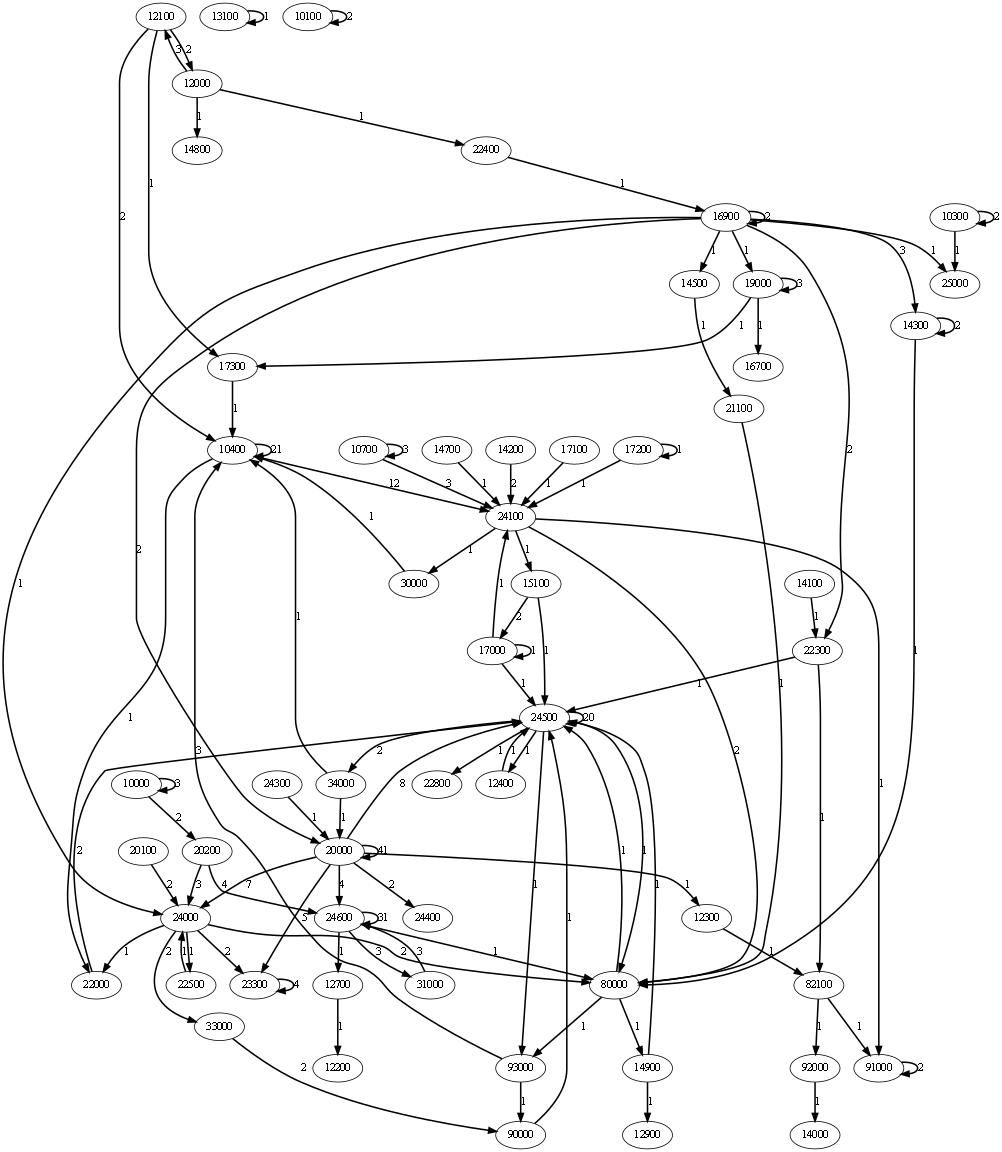

In [85]:
BN = createBN()
draw(BN)